# **UNICEF Indicator Data Warehouse** - SDMX REST API Web Service

In [41]:
# import necessary libraries 
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

Connecting to the UNICEF's data warehouse using the **Statistical Data and Metadata eXchange** (SDMX) standard.

In [42]:
endpoint = "https://sdmx.data.unicef.org/ws/public/sdmxapi/rest"

## **1. STEP: select a Data Flow**

Data Flows contain a set of data with a common structure and usually group similar topics. So I first use the API to get a list of all those Data Flows. 

This requires adding the following to the endpoint and providing the parameters for ```format```, ```detail``` and ```reference```. I chose to get the data in the **JSON format**, with **full detail** and **no references**. 

In [43]:
dataflow_endpoint = "/dataflow/all/all/latest"
dataflow_params = {
    "format": "sdmx-json",
    "detail": "full",
    "reference": "none",
}

In [44]:
# get the response and checking the status code 
dataflow_response = requests.get(url=endpoint+dataflow_endpoint, params=dataflow_params)
print(dataflow_response.status_code)

# converting the response into JSON format, printing the response  
dataflows = dataflow_response.json()['data']['dataflows']
# uncomment the next line to see the complete response 
# pprint(dataflows)

200


In [45]:
# this prints out all the Data Flows and their necessary keys
for dflow in dataflows:
    # those values will be necessary for the next API call
    print(f"name: {dflow['name']} - id: {dflow['id']} - agency-id: {dflow['agencyID']} - dataflow-version: {dflow['version']}")

name: Brazil Country Office - id: BRAZIL_CO - agency-id: BRAZIL_CO - dataflow-version: 1.0
name: Brazil SELO - id: BRAZIL_CO_SELO - agency-id: BRAZIL_CO - dataflow-version: 1.0
name: CAP 2030 - id: CAP2030 - agency-id: CAP2030 - dataflow-version: 1.0
name: Coundown 2030 - id: CD2030 - agency-id: CD2030 - dataflow-version: 1.0
name: Countdown - coverage indicators - id: CDCOV - agency-id: CD2030 - dataflow-version: 1.0
name: Countdown - demographic indicators - id: CDDEM - agency-id: CD2030 - dataflow-version: 1.0
name: Countdown - drivers indicators - id: CDDRIVER - agency-id: CD2030 - dataflow-version: 1.0
name: Countdown - coverage - equiplot data - id: CDEQUIPLOT - agency-id: CD2030 - dataflow-version: 1.0
name: Countdown - tier 2 indicators - id: CDT2 - agency-id: CD2030 - dataflow-version: 1.0
name: CD2030 All - id: CONSOLIDATED - agency-id: CD2030 - dataflow-version: 1.0
name: EAPRO Cross Sector Indicators - id: DF_EAPRO_CROSS_SECTOR - agency-id: EAPRO - dataflow-version: 1.0
nam

I chose  ```name: Demography - id: DM - agency-id: UNICEF - dataflow-version: 1.0```  for further exploration.

To get hold of the actual data later, it's necessary to remember the **id**, the **id of the agency** and the **version** of the chosen Data Flow. 

In [46]:
SELECTED_DFLOW = 'DEMOGRAPHY'
SELECTED_DFLOW_ID = 'DM'
SELECTED_AGENCY_ID = 'UNICEF'
SELECTED_DFLOW_VER = "1.0"

## **2. STEP: explore the structure of the selected Data Flow**

This structure uses the **Data Structure Definition** (DSD) to achieve reusability between different Data Flows. It comprises concepts that can have the usage roles of a dimension, an attribute or a measure. 

A new addition to the endpoint, including the agency ID of the selected Data Flow, must be made to get hold of the structure. The parameters that are sent with the API call stay the same.

In [47]:
structure_endpoint = f"/datastructure/{SELECTED_AGENCY_ID}/{SELECTED_DFLOW}/latest"
structure_params = {
    "format": "sdmx-json",
    "detail": "full",
    "reference": "none",
}

In [48]:
# get the response and checking the status code 
structure_response = requests.get(url=endpoint+structure_endpoint, params=structure_params)
print(dataflow_response.status_code)

# get hold of the dataStructures 
selected_structure = structure_response.json()['data']['dataStructures'][0]

# display the structure in JSON format 
pprint(selected_structure)


200
{'agencyID': 'UNICEF',
 'dataStructureComponents': {'attributeList': {'attributes': [{'assignmentStatus': 'Conditional',
                                                               'attributeRelationship': {'primaryMeasure': 'OBS_VALUE'},
                                                               'conceptIdentity': 'urn:sdmx:org.sdmx.infomodel.conceptscheme.Concept=UNICEF:UNICEF_CONCEPTS(1.0).OBS_STATUS',
                                                               'id': 'OBS_STATUS',
                                                               'links': [{'hreflang': 'en',
                                                                          'rel': 'self',
                                                                          'type': 'dataattribute',
                                                                          'uri': 'https://raw.githubusercontent.com/sdmx-twg/sdmx-json/develop/structure-message/tools/schemas/1.0/sdmx-json-structure-schema.json',
    

Let's explore the concepts that were contained in the API response at little bit more. The key to access those lists is the ```dataStructureComponents``` key.

In [49]:
datastructure_comp = selected_structure['dataStructureComponents']

### Dimensions

In [50]:
# get the dimensions
dimensions_json = datastructure_comp['dimensionList']

dimensions = [(dim['id'], dim['position']) for dim in dimensions_json['dimensions']]
print(f'dimensions: {dimensions}')

time_dimensions = [(tdim['id'],tdim['position']) for tdim in dimensions_json['timeDimensions']]
print(f'time dimensions: {time_dimensions}')

dimensions: [('REF_AREA', 1), ('INDICATOR', 2), ('RESIDENCE', 3), ('SEX', 4), ('AGE', 5)]
time dimensions: [('TIME_PERIOD', 6)]


The ```dataStructureComponents``` for the Demography-Data Flow includes **6 dimensions total**, with the ```TIME_PERIOD``` in its own list of ```timeDimensions```. The positions at the second position in the tuple are required when making queries for specific data slices later. 

### Attributes

In [51]:
# get the attributes
attributes_json = datastructure_comp['attributeList']
attributes = attributes_json['attributes']

for att in attributes:
    print(f"{att['id']} - relation: {att['attributeRelationship']}")

OBS_STATUS - relation: {'primaryMeasure': 'OBS_VALUE'}
OBS_CONF - relation: {'primaryMeasure': 'OBS_VALUE'}
DATA_SOURCE - relation: {'primaryMeasure': 'OBS_VALUE'}
UNIT_MEASURE - relation: {'dimensions': ['REF_AREA', 'RESIDENCE', 'SEX', 'AGE']}
UNIT_MULTIPLIER - relation: {'dimensions': ['REF_AREA', 'RESIDENCE', 'SEX', 'AGE']}
COVERAGE_TIME - relation: {'primaryMeasure': 'OBS_VALUE'}
FREQ_COLL - relation: {'primaryMeasure': 'OBS_VALUE'}
SOURCE_LINK - relation: {'dimensions': ['REF_AREA', 'RESIDENCE', 'SEX', 'AGE']}
TIME_PERIOD_METHOD - relation: {'primaryMeasure': 'OBS_VALUE'}
SERIES_FOOTNOTE - relation: {'dimensions': ['INDICATOR']}
OBS_FOOTNOTE - relation: {'primaryMeasure': 'OBS_VALUE'}


There are **11 different attributes** that can be attached to different levels in the Demography-Data Flow.


## **3. STEP: query the desired slice of data**

In [52]:
complete_data_endpoint = f"/data/{SELECTED_AGENCY_ID},{SELECTED_DFLOW_ID},{SELECTED_DFLOW_VER}/all"
complete_data_params = {
    "format": "sdmx-json"
}

This would get hold of the complete dataset within this chosen Data Flow and version, but it's also possible to get just a piece of this dataset.

Getting just a slice of the data is possible by specifying specific values for the dimensions. Let's say we want to select the following:

- for the ```REF_AREA``` **Western Europe**
- for the ```INDICATOR``` **everything**
- for the ```RESIDENCE``` **just the total**
- for the ```SEX``` **just the total**
- for the ```AGE``` **everything**

The possible values for those dimensions can be found in the **Codelist** for this Data Flow. To get hold of this Codelist, another API call is necessary. The string that has to be added to the endpoint is the same as for getting the complete data, but with the parameters, the ```detail``` is limited to ```structureOnly```.

In [53]:
codelist_endpoint = f"/data/{SELECTED_AGENCY_ID},{SELECTED_DFLOW_ID},{SELECTED_DFLOW_VER}/all"
codelist_params = {
    "format": "sdmx-json",
    "detail": "structureOnly"
}

In [54]:
# get the response and checking the status code 
codelist_response = requests.get(url=endpoint+codelist_endpoint, params=codelist_params)
print(codelist_response.status_code)

codelist = codelist_response.json()['structure']['dimensions']['observation']
# uncomment next line to print codelist
# pprint(codelist)

200


The following picture is a screenshot from the Codelist returned from the API call. The Codelist provides a list of all the dimensions and all possible ```values``` for them. Because I wanted to limited the ```REF_AREA```, ```RESIDENCE``` and ```SEX``` let's look at the possible values for those: 


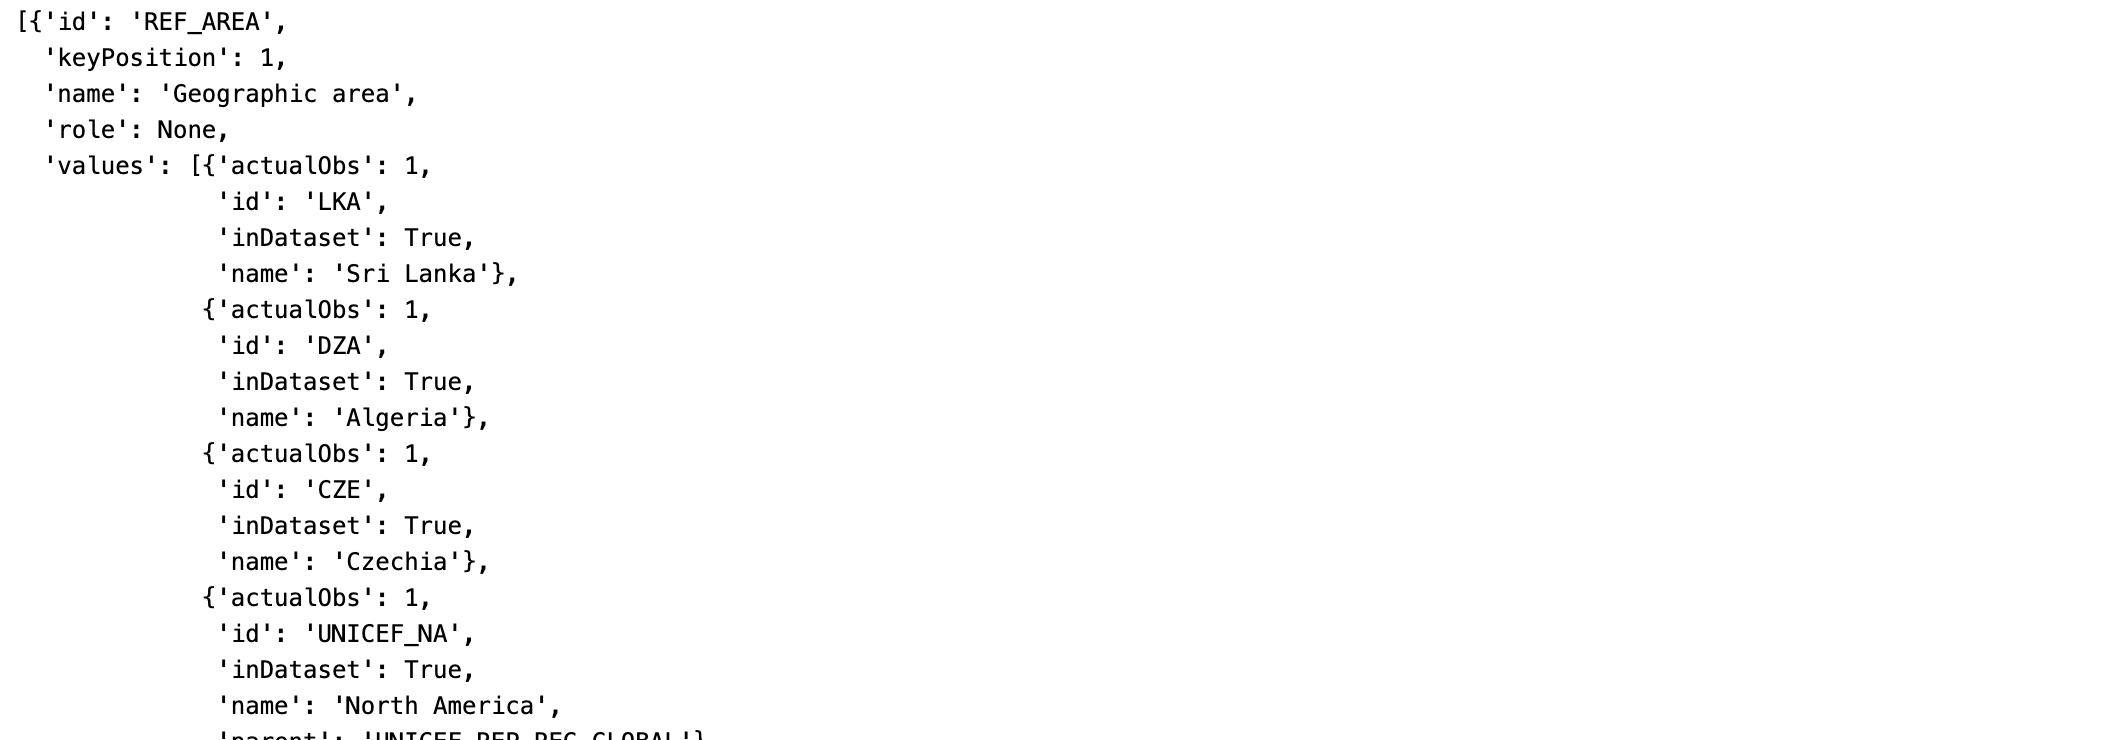

Looking for the ```REF_AREA``` to select only Western Europe. The order of dimensions will be the same as before; therefore, I know that the ```REF_AREA``` will be the first dimension in the list.

In [55]:
ref_area_values = [(v['name'], v['id']) for v in codelist[0]['values']]   
# this prints a list of tuples containing the name of the country or region and the id 
print(ref_area_values)

# search for the id of Western Europe
west_eu_id = [i for (n, i) in ref_area_values if n == "Western Europe"]
print(f"ID of Western Europe: {west_eu_id[0]}")


[('Sri Lanka', 'LKA'), ('Algeria', 'DZA'), ('Czechia', 'CZE'), ('North America', 'UNICEF_NA'), ('Jordan', 'JOR'), ('Trinidad and Tobago', 'TTO'), ('Spain', 'ESP'), ('Afghanistan', 'AFG'), ('Eswatini', 'SWZ'), ('South Asia', 'UNICEF_ROSA'), ("Lao People's Democratic Republic", 'LAO'), ('Türkiye', 'TUR'), ('Europe and Central Asia', 'UNICEF_ECARO'), ('Bosnia and Herzegovina', 'BIH'), ('Grenada', 'GRD'), ('Virgin Islands U.S.', 'VIR'), ('Greece', 'GRC'), ('Niue', 'NIU'), ('Saint Barthélemy', 'BLM'), ('Italy', 'ITA'), ('Switzerland', 'CHE'), ('Dominican Republic', 'DOM'), ('Bangladesh', 'BGD'), ('Cabo Verde', 'CPV'), ('Gabon', 'GAB'), ('Lesotho', 'LSO'), ('Saint Pierre and Miquelon', 'SPM'), ('Belarus', 'BLR'), ('Rwanda', 'RWA'), ('Isle of Man', 'IMN'), ('Eritrea', 'ERI'), ('Germany', 'DEU'), ('Luxembourg', 'LUX'), ('Estonia', 'EST'), ('New Caledonia', 'NCL'), ('Guatemala', 'GTM'), ('Somalia', 'SOM'), ('Bermuda', 'BMU'), ('French Guiana', 'GUF'), ('Mauritius', 'MUS'), ('Mayotte', 'MYT'), (

Next let's get the value for ```RESIDENCE``` which should be third in the list:

In [56]:
residence_values = [(v['name'], v['id']) for v in codelist[2]['values']]
print(residence_values)

[('Total', '_T')]


And at last the value for ```SEX``` which should be fourth: 

In [57]:
sex_values = [(v['name'], v['id']) for v in codelist[3]['values']]
print(sex_values)

[('Female', 'F'), ('Total', '_T'), ('Male', 'M')]


Now those dimension values can be used in the query string:

- select **Western Europe** as reference area: ```UNICEF_WE```
- select **all residencies**: ```_T```
- select **all genders**: ```_T```

Those parameters have to be added to the endpoint string **separated by dots**. Multiple values for a dimension should be separated by a "+". 

**Important**: The query string has to contain every dimension. If nothing should be specified, it has to be treated like being left out by just typing the next separating dot. The order is the same as in the dimensions list shown above or as specified under their ```position``` attribute. 

**REF_AREA.~~INDICATOR~~.RESIDENCE.SEX.~~AGE~~** -> final string: **UNICEF_WE.._T._T.**

In [58]:
QUERY_STR = "UNICEF_WE.._T._T."

In [59]:
data_endpoint = f"/data/{SELECTED_AGENCY_ID},{SELECTED_DFLOW_ID},{SELECTED_DFLOW_VER}/{QUERY_STR}"
data_params = {
    "format": "sdmx-json",
}

In [60]:
# get the response
data_response = requests.get(url=endpoint+data_endpoint, params=data_params).json()['data']

for list in data_response:
    print(list)

dataSets
structure


After retrieving the response in the JSON format, it's necessary to **connect the data points with their corresponding structure**. Those are separated in ```structure``` and ```dataSets```.

Let's first look into the ```structure```:

Using the ```dimensions``` key, we find two further keys: ```series``` which contains the **dimensions 1 to 5** and ```observation``` which contains **dimension number 6**, the ```TIME_PERIOD```. Those separated list indicate the different levels of attachment. 

In [61]:
# dimensions attached at series level
ser_dim_response = data_response['structure']['dimensions']['series']
pprint(ser_dim_response)

[{'id': 'REF_AREA',
  'keyPosition': 0,
  'name': 'Geographic area',
  'role': None,
  'values': [{'id': 'UNICEF_WE', 'name': 'Western Europe'}]},
 {'id': 'INDICATOR',
  'keyPosition': 1,
  'name': 'Indicator',
  'role': None,
  'values': [{'description': 'Total population',
              'id': 'DM_POP_TOT',
              'name': 'Total population'},
             {'description': 'Population under age 18',
              'id': 'DM_POP_U18',
              'name': 'Population under age 18'},
             {'description': 'Population under age 5',
              'id': 'DM_POP_U5',
              'name': 'Population under age 5'},
             {'description': 'Adolescent population aged 10-19',
              'id': 'DM_POP_ADLCNT',
              'name': 'Adolescent population (10-19)'},
             {'id': 'DM_POP_15TO24', 'name': 'Youth population from 15 to 24'},
             {'description': 'Average exponential rate of growth of the '
                             'population over one year',
 

In [62]:
# dimensions attached at observation level
obs_dim_response = data_response['structure']['dimensions']['observation']
pprint(obs_dim_response)

[{'id': 'TIME_PERIOD',
  'keyPosition': 5,
  'name': 'Time period',
  'role': 'time',
  'values': [{'end': '1950-12-31T23:59:59',
              'id': '1950',
              'name': '1950',
              'start': '1950-01-01T00:00:00'},
             {'end': '1951-12-31T23:59:59',
              'id': '1951',
              'name': '1951',
              'start': '1951-01-01T00:00:00'},
             {'end': '1952-12-31T23:59:59',
              'id': '1952',
              'name': '1952',
              'start': '1952-01-01T00:00:00'},
             {'end': '1953-12-31T23:59:59',
              'id': '1953',
              'name': '1953',
              'start': '1953-01-01T00:00:00'},
             {'end': '1954-12-31T23:59:59',
              'id': '1954',
              'name': '1954',
              'start': '1954-01-01T00:00:00'},
             {'end': '1955-12-31T23:59:59',
              'id': '1955',
              'name': '1955',
              'start': '1955-01-01T00:00:00'},
             {'end':

Looking at those dimensions from the response, we can see the ```TIME_PERIOD``` which goes from 1950 to 2023, the ```REF_AREA``` which I limited to only return values for ```UNICEF_WE``` ('Western Europe'), all those different values for the ```INDICATOR```, and the ```RESIDENCE```, ```SEX``` and ```AGE``` all limited to 'Total'.

Next, let's get an overview of the attributes, which are also split into their different attachment levels: ```series``` and ```observation```. 

In [63]:
# attributes attached at series level
ser_attr_response = data_response['structure']['attributes']['series']
pprint(ser_attr_response)

[{'id': 'UNIT_MEASURE',
  'name': 'Unit of measure',
  'relationship': {'dimensions': ['REF_AREA', 'RESIDENCE', 'SEX', 'AGE']},
  'role': None,
  'values': [{'id': 'PS', 'name': 'Persons'},
             {'id': 'PCNT', 'name': '%'},
             {'id': 'NUMBER', 'name': 'Number'},
             {'id': 'YR', 'name': 'Years'}]},
 {'id': 'UNIT_MULTIPLIER',
  'name': 'Unit multiplier',
  'relationship': {'dimensions': ['REF_AREA', 'RESIDENCE', 'SEX', 'AGE']},
  'role': None,
  'values': [{'description': 'In scientific notation, expressed as ten raised '
                             'to the power of three (10^3)',
              'id': '3',
              'name': 'Thousands'},
             {'description': 'In scientific notation, expressed as ten raised '
                             'to the power of zero (10^0)',
              'id': '0',
              'name': 'Units'}]},
 {'id': 'SOURCE_LINK',
  'name': 'Citation of or link to the data source',
  'relationship': {'dimensions': ['REF_AREA', 'RES

In [64]:
# attributes attached at observation level
obs_attr_response = data_response['structure']['attributes']['observation']
pprint(obs_attr_response)

[{'id': 'OBS_STATUS',
  'name': 'Observation Status',
  'relationship': {'primaryMeasure': 'OBS_VALUE'},
  'role': None,
  'values': [{'id': 'E', 'name': 'Estimated value'},
             {'id': 'F', 'name': 'Forecast value'}]},
 {'id': 'OBS_CONF',
  'name': 'Observation confidentaility',
  'relationship': {'primaryMeasure': 'OBS_VALUE'},
  'role': None,
  'values': []},
 {'id': 'DATA_SOURCE',
  'name': 'Data Source',
  'relationship': {'primaryMeasure': 'OBS_VALUE'},
  'role': None,
  'values': [{'id': 'United Nations, Department of Economic and Social '
                    'Affairs, Population Division (2022). World Population '
                    'Prospects 2022, Online Edition.',
              'name': 'United Nations, Department of Economic and Social '
                      'Affairs, Population Division (2022). World Population '
                      'Prospects 2022, Online Edition.'},
             {'id': 'United Nations, Department of Economic and Social '
                    'A

Now it's time to retrieve the actual data points:

In [65]:
dpoints_response = data_response['dataSets']
# to view uncomment the next line
# pprint(dpoints_response)

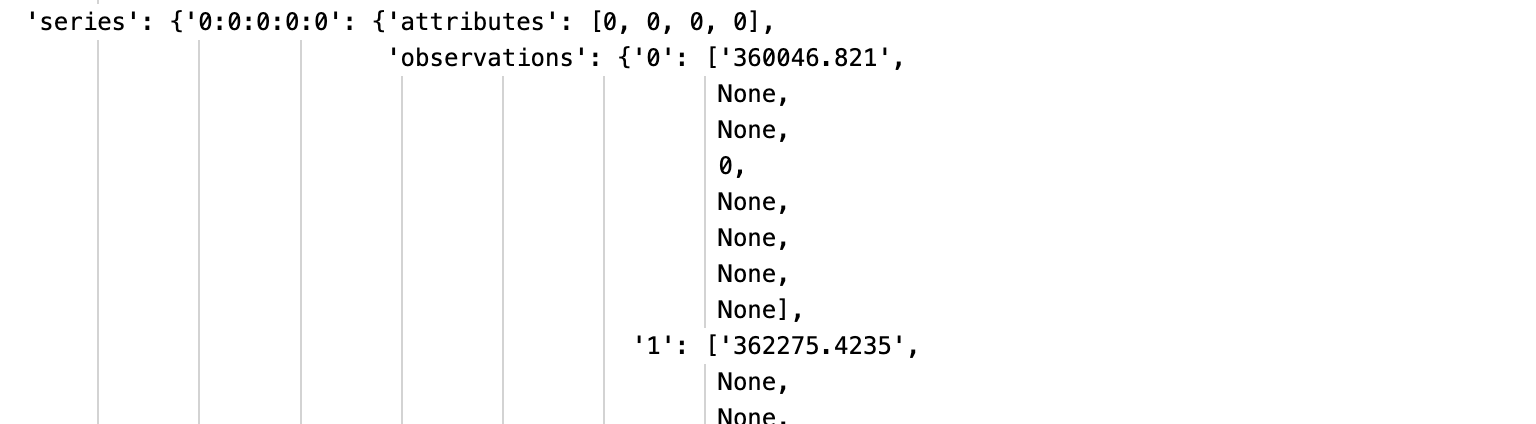

Each data series is uniquely identified by its **Key**, comprised of the dimensions attached at series level (in this instance: ```'0:0:0:0:0'```). In this case, only the second number changes because that is the number corresponding with the ```INDICATOR```.

In [66]:
# get the different keys of the data points and their corresponding dimensions  
for point in dpoints_response[0]['series']:
    print(f"{point} - "
          f"{ser_dim_response[0]['values'][int(point.split(':')[0])]['name']} : "
          f"{ser_dim_response[1]['values'][int(point.split(':')[1])]['name']} : "
          f"{ser_dim_response[2]['values'][int(point.split(':')[2])]['name']} : "
          f"{ser_dim_response[3]['values'][int(point.split(':')[3])]['name']} : "
          f"{ser_dim_response[4]['values'][int(point.split(':')[4])]['name']}")

0:0:0:0:0 - Western Europe : Total population : Total : Total : Total
0:1:0:0:0 - Western Europe : Population under age 18 : Total : Total : Total
0:2:0:0:0 - Western Europe : Population under age 5 : Total : Total : Total
0:3:0:0:0 - Western Europe : Adolescent population (10-19) : Total : Total : Total
0:4:0:0:0 - Western Europe : Youth population from 15 to 24 : Total : Total : Total
0:5:0:0:0 - Western Europe : Population annual growth rate : Total : Total : Total
0:6:0:0:0 - Western Europe : Number of births : Total : Total : Total
0:7:0:0:0 - Western Europe : Total fertility rate : Total : Total : Total
0:8:0:0:0 - Western Europe : Life expectancy : Total : Total : Total
0:9:0:0:0 - Western Europe : Total dependency ratio : Total : Total : Total
0:10:0:0:0 - Western Europe : Child dependency ratio : Total : Total : Total
0:11:0:0:0 - Western Europe : Old age dependency ratio : Total : Total : Total
0:12:0:0:0 - Western Europe : Share of urban population : Total : Total : Total
0:

Next are the attributes attached at series level. In this instance: ```[0, 0, 0, 0]```.

In [67]:
example = dpoints_response[0]['series']['0:0:0:0:0']
print(example)

{'attributes': [0, 0, 0, 0], 'observations': {'0': ['360046.821', 0, None, 0, None, None, None, None], '1': ['362275.4235', 0, None, 0, None, None, None, None], '2': ['364615.6255', 0, None, 0, None, None, None, None], '3': ['367236.9075', 0, None, 0, None, None, None, None], '4': ['369958.3805', 0, None, 0, None, None, None, None], '5': ['372647.2225', 0, None, 0, None, None, None, None], '6': ['375280.3495', 0, None, 0, None, None, None, None], '7': ['377958.374', 0, None, 0, None, None, None, None], '8': ['380877.269', 0, None, 0, None, None, None, None], '9': ['383924.0725', 0, None, 0, None, None, None, None], '10': ['386932.4745', 0, None, 0, None, None, None, None], '11': ['390053.8575', 0, None, 0, None, None, None, None], '12': ['393287.6465', 0, None, 0, None, None, None, None], '13': ['396502.2875', 0, None, 0, None, None, None, None], '14': ['399858.8165', 0, None, 0, None, None, None, None], '15': ['403165.982', 0, None, 0, None, None, None, None], '16': ['406302.0965', 0,

In [68]:
for i, v in enumerate(example['attributes']):
    print(f"{ser_attr_response[i]['id']}: {v} -> {ser_attr_response[i]['values'][v]['name']}")

UNIT_MEASURE: 0 -> Persons
UNIT_MULTIPLIER: 0 -> Thousands
SOURCE_LINK: 0 -> https://population.un.org/wpp/
SERIES_FOOTNOTE: 0 -> Data from 236 countries/areas with population more than 1K from WPP2022, countries/areas less than 1K population is not shown but calculated when aggregated.


Finally, the concepts at the observation level: 

```'observations': {'0': ['360046.821', None, None, 0, None, None, None, None],}```

First, the dimensions attached at the observation level, so in this case, the ```TIME_PERIOD```.

The following list starts with the ```OBS_VALUE```, listed under ```primaryMeasure```. The other values correspond with the attributes at the observation-level.

In [69]:
print(f"'0' -> TIME_PERIOD: {obs_dim_response[0]['values'][0]['name']}")

'0' -> TIME_PERIOD: 1950


In [70]:
obs_attr_response[0]

{'id': 'OBS_STATUS',
 'name': 'Observation Status',
 'relationship': {'primaryMeasure': 'OBS_VALUE'},
 'role': None,
 'values': [{'id': 'E', 'name': 'Estimated value'},
  {'id': 'F', 'name': 'Forecast value'}]}

In [71]:
for i, v in enumerate(example['observations']['0']):
    if i == 0: 
        print(f"OBS_VALUE: {v}\n")
    else:
        print(f"{obs_attr_response[i-1]['name']}: {v}")

OBS_VALUE: 360046.821

Observation Status: 0
Observation confidentaility: None
Data Source: 0
The period of time for which data are provided: None
Time interval at which the source data are collected: None
Time period activity related to when the data are collected: None
Observation footnote: None


## **4. STEP: put the data into a Pandas DataFrame**

Let's explore how the number of births in Western Europe changed over the years. To do this I'll first create a DataFrame with all the useful values. 

In [72]:
# create a dictionary which will be converted into a pandas DataFrame later
data = {}

# going over all those dimension keys 
for k, v in dpoints_response[0]['series'].items():
    # because only the 'INDICATOR' changes I will only keep that 
    indicator_index = int(k.split(':')[1])

    # this will get the 'id' of the corresponding value in the 'INDICATOR' dimension 
    # this id will be used as column later and therefore used as a key in the new dict 
    indicator_key = ser_dim_response[1]['values'][indicator_index]['id']

    # to get the values I'll loop over the different keys for the observation dimension corresponding with the 'TIME_PERIOD'
    # I'll only use the observation values and put them into a consecutive list 
    # later the years will be used a indices 
    indicator_values = []
    for i, j in enumerate(obs_dim_response[0]['values']):
        try: 
            indicator_values.append(dpoints_response[0]['series'][k]['observations'][str(i)][0])
        except KeyError:
            indicator_values.append(None)
    
    # append the attributes to preserve additional information 
    for g, h in enumerate(v['attributes']):
        try:
            indicator_values.append(ser_attr_response[g]['values'][h]['name'])
        except TypeError:
            indicator_values.append(None)
    
    # put everything together 
    data[indicator_key] = indicator_values

print(data)


{'DM_POP_TOT': ['360046.821', '362275.4235', '364615.6255', '367236.9075', '369958.3805', '372647.2225', '375280.3495', '377958.374', '380877.269', '383924.0725', '386932.4745', '390053.8575', '393287.6465', '396502.2875', '399858.8165', '403165.982', '406302.0965', '409355.0465', '412150.778', '414640.9005', '416909.4875', '419295.613', '421868.879', '424262.833', '426507.1465', '428512.642', '430249.785', '431967.585', '433614.523', '435202.746', '436910.7285', '438522.5615', '439902.19', '441154.3725', '442378.2025', '443621.7565', '444878.1335', '446241.4085', '447676.3405', '449124.0425', '450612.051', '452198.8625', '453827.579', '455306.01', '456599.9255', '457743.3515', '458779.5985', '459809.941', '460814.1455', '461796.773', '463032.85', '464362.7675', '465891.093', '467843.811', '470007.2145', '472199.0885', '474373.821', '476884.1735', '479478.533', '481663.224', '483558.998', '485321.516', '486845.1985', '488064.7255', '489231.7235', '490441.161', '491694.204', '492993.99'

In [73]:
# create indices list for the DataFrame with years from 'TIME_PERIOD' dimension 
indices = [int(obs_dim_response[0]['values'][i]['id']) for i, v in enumerate(obs_dim_response[0]['values'])]

# create indices for the attributes that were added to the end 
attr_indices = [n['name'] for n in ser_attr_response]

# create the DataFrame
df = pd.DataFrame(data, index=indices+attr_indices)

df

,DM_POP_TOT,DM_POP_U18,DM_POP_U5,DM_POP_ADLCNT,DM_POP_15TO24,DM_POP_GRT,DM_BRTS,DM_FRATE_TOT,DM_LIFE_EXP,DM_DPR_TOT,DM_DPR_CHD,DM_DPR_OLD,DM_POP_URBN,DM_POP_U_GRT,DM_NET_MG_RATE,DM_POP_ADLCNT_PROP
1950,360046.821,107355.514,32727.9435,57839.9075,57355.14,None,7101.272,2.57,65.361,51.65,37.991,13.66,59.3959823573379,None,-2.377,16.0645516434098
1951,362275.4235,107823.663,33117.8155,57571.1155,57110.789,None,6973.249,2.527,65.384,51.789,37.949,13.84,59.7887543033316,None,-1.667,15.8915321784172
1952,364615.6255,108357.641,33085.907,57211.0155,56878.8765,None,6943.765,2.52,66.47,51.992,37.966,14.026,60.1593468440138,None,-1.453,15.690774475599
1953,367236.9075,108875.453,32938.71,57023.892,56695.9235,None,6916.519,2.51,66.937,52.209,37.981,14.228,60.5260440876617,None,-0.364,15.5278216419464
1954,369958.3805,109474.391,32795.505,57007.0285,56595.2495,None,6941.175,2.517,67.576,52.407,37.994,14.413,60.8996163003978,None,-0.952,15.4090382877541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023,500906.348,91342.9615,23286.6345,53334.661,54135.9175,None,4618.262,1.528,82.301,56.911,23.566,33.344,77.7037053122399,None,-0.871,10.6476312813668
Unit of measure,Persons,Persons,Persons,Persons,Persons,%,Persons,Number,Years,%,%,%,%,%,Number,%
Unit multiplier,Thousands,Thousands,Thousands,Thousands,Thousands,Units,Thousands,None,Units,Units,Units,Units,Units,Units,None,Units
Citation of or link to the data source,https://population.un.org/wpp/,https://population.un.org/wpp/,https://population.un.org/wpp/,https://population.un.org/wpp/,https://population.un.org/wpp/,https://population.un.org/wpp/,https://population.un.org/wpp/,https://population.un.org/wpp/,https://population.un.org/wpp/,https://population.un.org/wpp/,https://population.un.org/wpp/,https://population.un.org/wpp/,https://population.un.org/wup/,https://population.un.org/wup/,https://population.un.org/wpp/,https://population.un.org/wpp/


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, 1950 to Series footnote
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   DM_POP_TOT          78 non-null     object
 1   DM_POP_U18          78 non-null     object
 2   DM_POP_U5           78 non-null     object
 3   DM_POP_ADLCNT       78 non-null     object
 4   DM_POP_15TO24       78 non-null     object
 5   DM_POP_GRT          6 non-null      object
 6   DM_BRTS             78 non-null     object
 7   DM_FRATE_TOT        77 non-null     object
 8   DM_LIFE_EXP         78 non-null     object
 9   DM_DPR_TOT          78 non-null     object
 10  DM_DPR_CHD          78 non-null     object
 11  DM_DPR_OLD          78 non-null     object
 12  DM_POP_URBN         78 non-null     object
 13  DM_POP_U_GRT        6 non-null      object
 14  DM_NET_MG_RATE      77 non-null     object
 15  DM_POP_ADLCNT_PROP  78 non-null     object
dtypes: object(16)
mem

Because all those values were treated as if they were strings the Dtypes are objects. This has to be changed in order to work with them as numerical values. I will also drop the ```DM_POP_GRT``` and ```DM_POP_U_GRT``` because they only contain 2 NaN values which is not very useful for time comparison. 

In [75]:
new_df = df.copy()

# drop columns with only 2 NaN values 
new_df.drop(columns=['DM_POP_GRT', 'DM_POP_U_GRT'], axis=1, inplace=True)

While the last four rows are helpful to get more information, like the unit measure and unit multiplier, it has to be dropped to do analysis. 

In [76]:
new_df.drop(index=attr_indices, axis=0, inplace=True)

In [77]:
# change Dtypes 
for col in new_df.columns:
    new_df[col] = pd.to_numeric(new_df[col])

new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74 entries, 1950 to 2023
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DM_POP_TOT          74 non-null     float64
 1   DM_POP_U18          74 non-null     float64
 2   DM_POP_U5           74 non-null     float64
 3   DM_POP_ADLCNT       74 non-null     float64
 4   DM_POP_15TO24       74 non-null     float64
 5   DM_BRTS             74 non-null     float64
 6   DM_FRATE_TOT        74 non-null     float64
 7   DM_LIFE_EXP         74 non-null     float64
 8   DM_DPR_TOT          74 non-null     float64
 9   DM_DPR_CHD          74 non-null     float64
 10  DM_DPR_OLD          74 non-null     float64
 11  DM_POP_URBN         74 non-null     float64
 12  DM_NET_MG_RATE      74 non-null     float64
 13  DM_POP_ADLCNT_PROP  74 non-null     float64
dtypes: float64(14)
memory usage: 8.7+ KB


Now I it's possible to explore how the number of births in Western Europe changed over the years. 

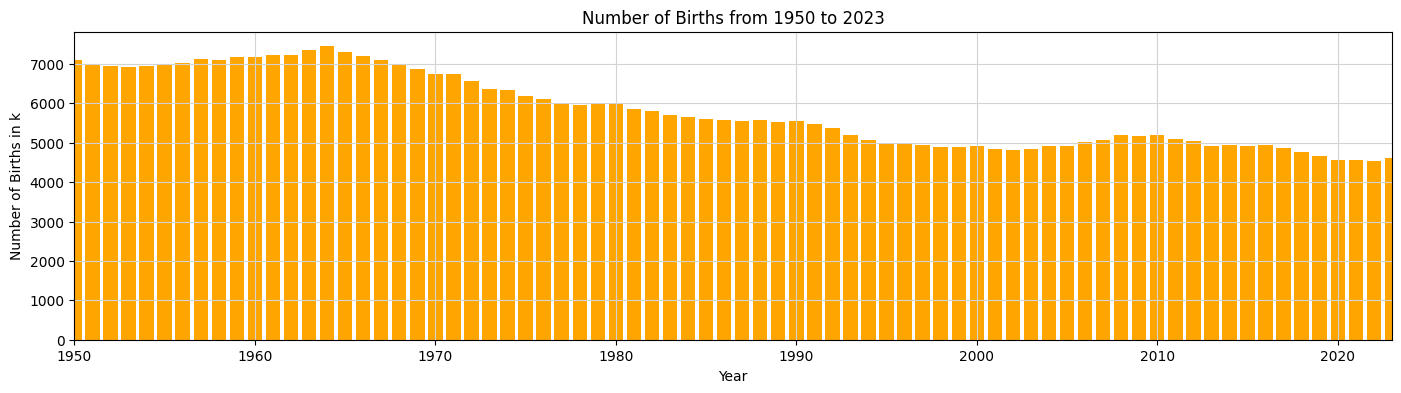

In [78]:
fig, ax = plt.subplots(figsize=(17,4))
plt.bar(
    x=new_df.index,
    height=new_df['DM_BRTS'],
    color='orange',
)

ax.grid(True, color="lightgrey")
plt.title('Number of Births from 1950 to 2023')
plt.ylabel('Number of Births in k')
plt.xlabel('Year')
plt.xlim(1950, 2023)

plt.show()

## **5. STEP: export desired data**

The DataFrame that was just created can easily be exported to CSV or Excel format for further data visualization with other tools. 

In [79]:
# export to csv
df.to_csv("my_sdmx_data.csv")

In [80]:
%pip install openpyxl
# export as Excel file 
df.to_excel("my_sdmx_data.xlsx")

Note: you may need to restart the kernel to use updated packages.


### **Read the article for further explanation:** https://medium.com/@schwebel.felix/sdmx-rest-web-service-eafe4107117c

**Useful Links and Sources:**
- https://sdmx.data.unicef.org/overview.html
- https://sdmx.org/
- https://ec.europa.eu/eurostat/web/sdmx-infospace/trainings-tutorials
- https://data.unicef.org/sdmx-api-documentation/